In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['axes.grid'] = True

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, Naive, AutoARIMA, AutoETS, AutoTheta

from utilsforecast.losses import smape
from utilsforecast.evaluation import evaluate

from sklearn.linear_model import LinearRegression

/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1u-hHAVt8VAzMWkAS8l1Zc6XWrtF16rOODL6qYkKXWo4/export?format=csv')
df.ds = pd.to_datetime(df.ds, format='%b %Y')
df

ParserError: Error tokenizing data. C error: Expected 421 fields in line 84, saw 7372


#EDA

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 167562 entries, 0 to 167561
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   unique_id  167562 non-null  str           
 1   ds         167562 non-null  datetime64[us]
 2   y          167562 non-null  float64       
dtypes: datetime64[us](1), float64(1), str(1)
memory usage: 4.6 MB


In [5]:
df.describe()

,ds,y
count,167562,167562.000000
mean,1986-12-05 20:37:11.131163,5000.323669
min,1857-01-01 00:00:00,10.000000
25%,1985-01-01 00:00:00,3596.000000
50%,1988-08-01 00:00:00,4850.000000
75%,1991-11-01 00:00:00,6135.000000
max,2006-11-01 00:00:00,86730.000000
std,NaN,2296.363075


In [6]:
print('n_series:', len(np.unique(df.unique_id.values)))

n_series: 1428


In [7]:
np.sort(df['ds'].unique())

array(['1857-01-01T00:00:00.000000', '1857-02-01T00:00:00.000000',
       '1857-03-01T00:00:00.000000', ..., '2006-09-01T00:00:00.000000',
       '2006-10-01T00:00:00.000000', '2006-11-01T00:00:00.000000'],
      shape=(1799,), dtype='datetime64[us]')

In [8]:
df.ds.value_counts()

ds
1990-01-01    1215
1990-02-01    1215
1990-03-01    1215
1990-04-01    1215
1990-05-01    1215
              ... 
1955-08-01       1
1955-09-01       1
1955-10-01       1
1955-11-01       1
1955-12-01       1
Name: count, Length: 1799, dtype: int64

In [9]:
df[df.ds.isin(['1857-01-01', '2006-11-01'])]

,unique_id,ds,y


In [10]:
display(df.unique_id.value_counts())

unique_id
N1879    144
N1881    144
N1882    144
N1883    144
N1884    144
        ... 
N1418     68
N1419     68
N2656     68
N2479     66
N2480     66
Name: count, Length: 1428, dtype: int64

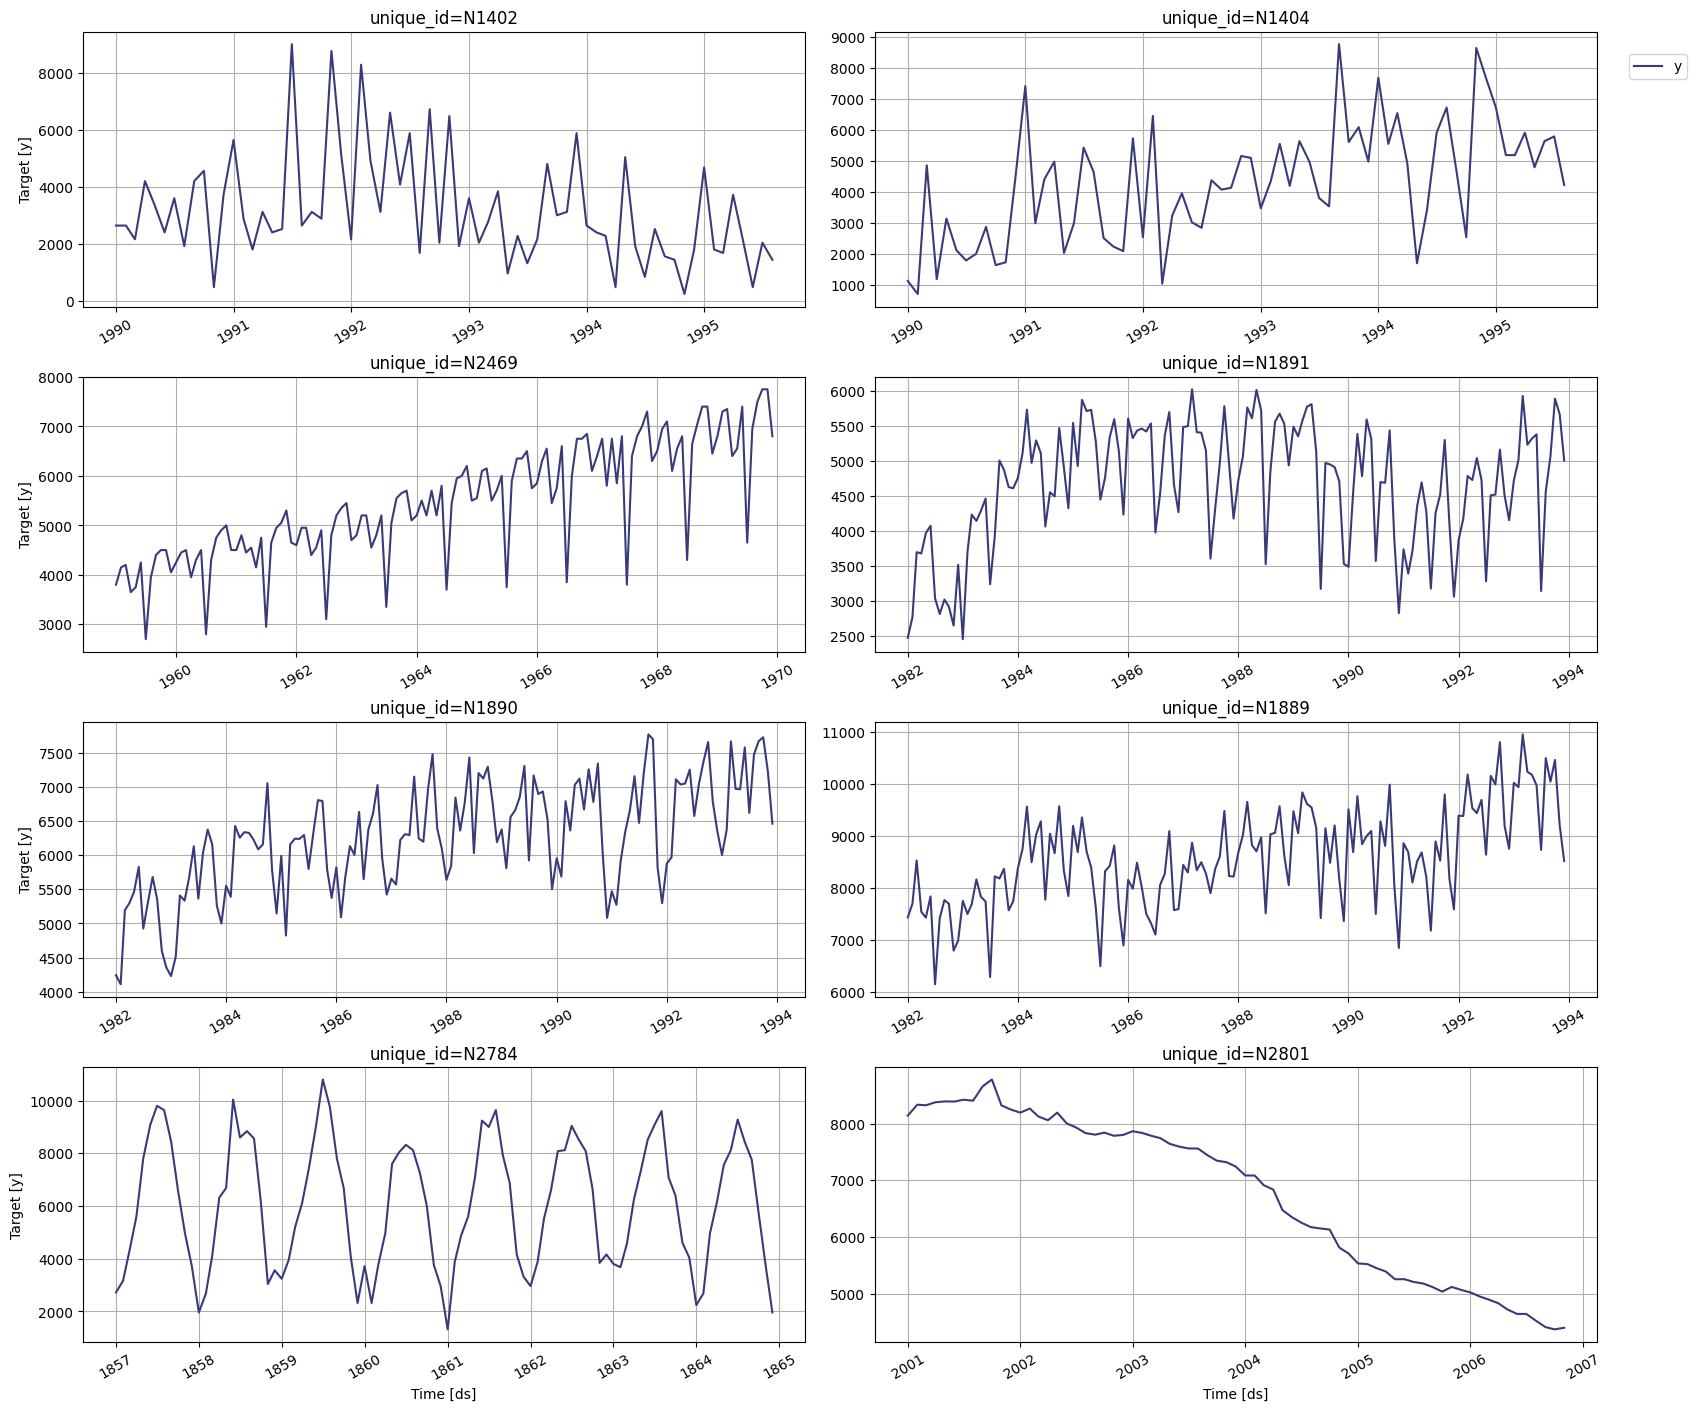

In [11]:
StatsForecast.plot(df, unique_ids=['N1402', 'N1404', 'N2469', #shortest
                                   'N1891', 'N1890', 'N1889', #longest
                                   'N2784', #oldest
                                   'N2801' #newest
                                   ])

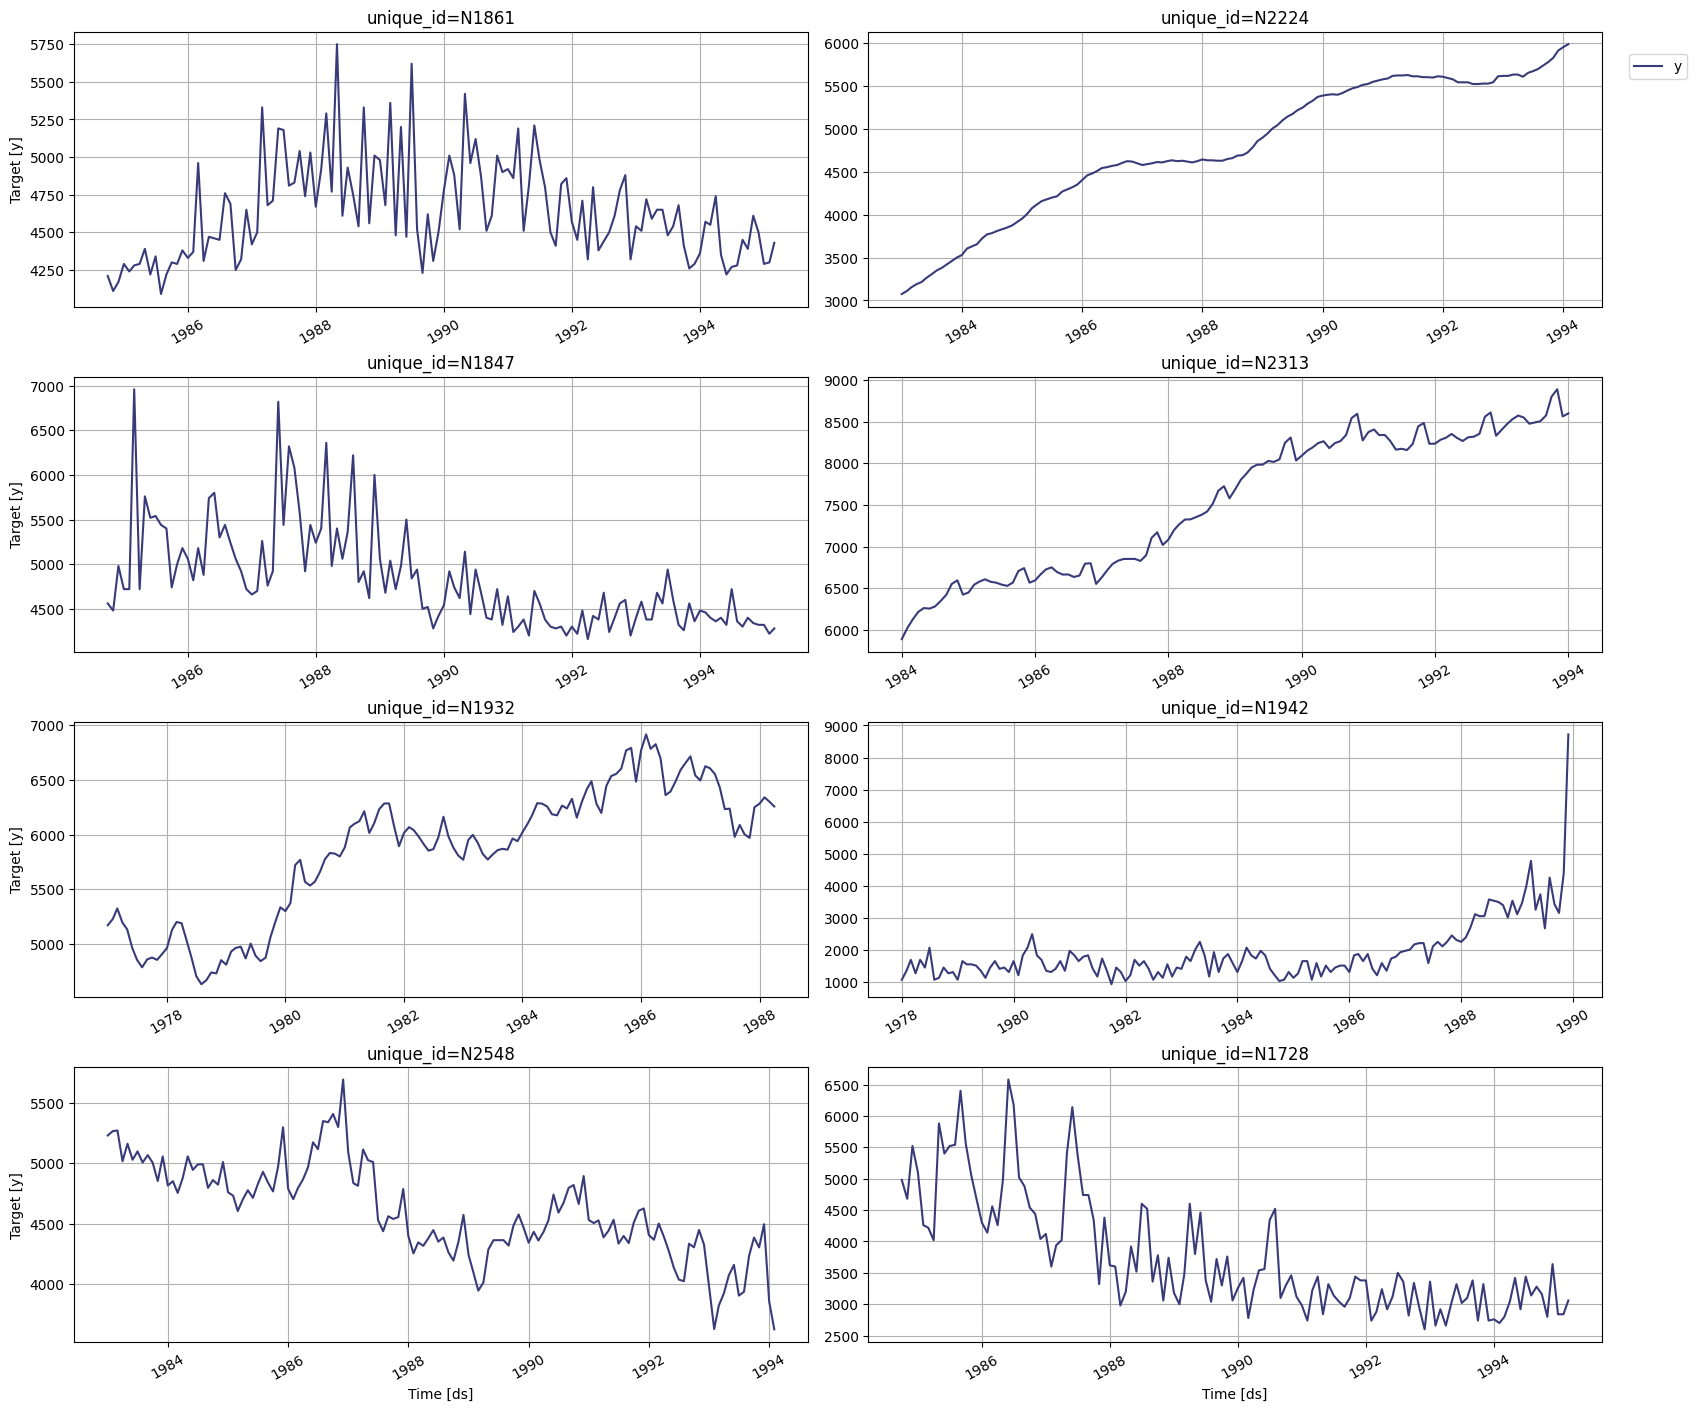

In [12]:
StatsForecast.plot(df)

In [13]:
df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)

In [14]:
series_stats = (
    df.groupby("unique_id")["y"]
      .agg(
          length="size",
          mean="mean",
          std="std"
      )
)

series_stats["cv"] = series_stats["std"] / series_stats["mean"]

In [15]:
def safe_autocorr(x, lag):
    if len(x) <= lag:
        return np.nan
    return x.autocorr(lag=lag)

acf1 = df.groupby("unique_id")["y"].apply(lambda x: safe_autocorr(x, 1))
acf12 = df.groupby("unique_id")["y"].apply(lambda x: safe_autocorr(x, 12))

series_stats["acf1"] = acf1
series_stats["acf12"] = acf12

In [16]:
def seasonal_strength_ratio(x):
    x = x.values
    if len(x) <= 12:
        return np.nan

    naive_err = np.mean(np.abs(x[1:] - x[:-1]))
    snaive_err = np.mean(np.abs(x[12:] - x[:-12]))

    if snaive_err == 0:
        return np.nan

    return naive_err / snaive_err

season_ratio = df.groupby("unique_id")["y"].apply(seasonal_strength_ratio)
series_stats["seasonal_ratio"] = season_ratio

In [17]:
def compute_trend_slope(x):
    x = x.values
    t = np.arange(len(x)).reshape(-1, 1)
    model = LinearRegression().fit(t, x)
    return model.coef_[0]

trend = df.groupby("unique_id")["y"].apply(compute_trend_slope)
series_stats["trend_slope"] = trend

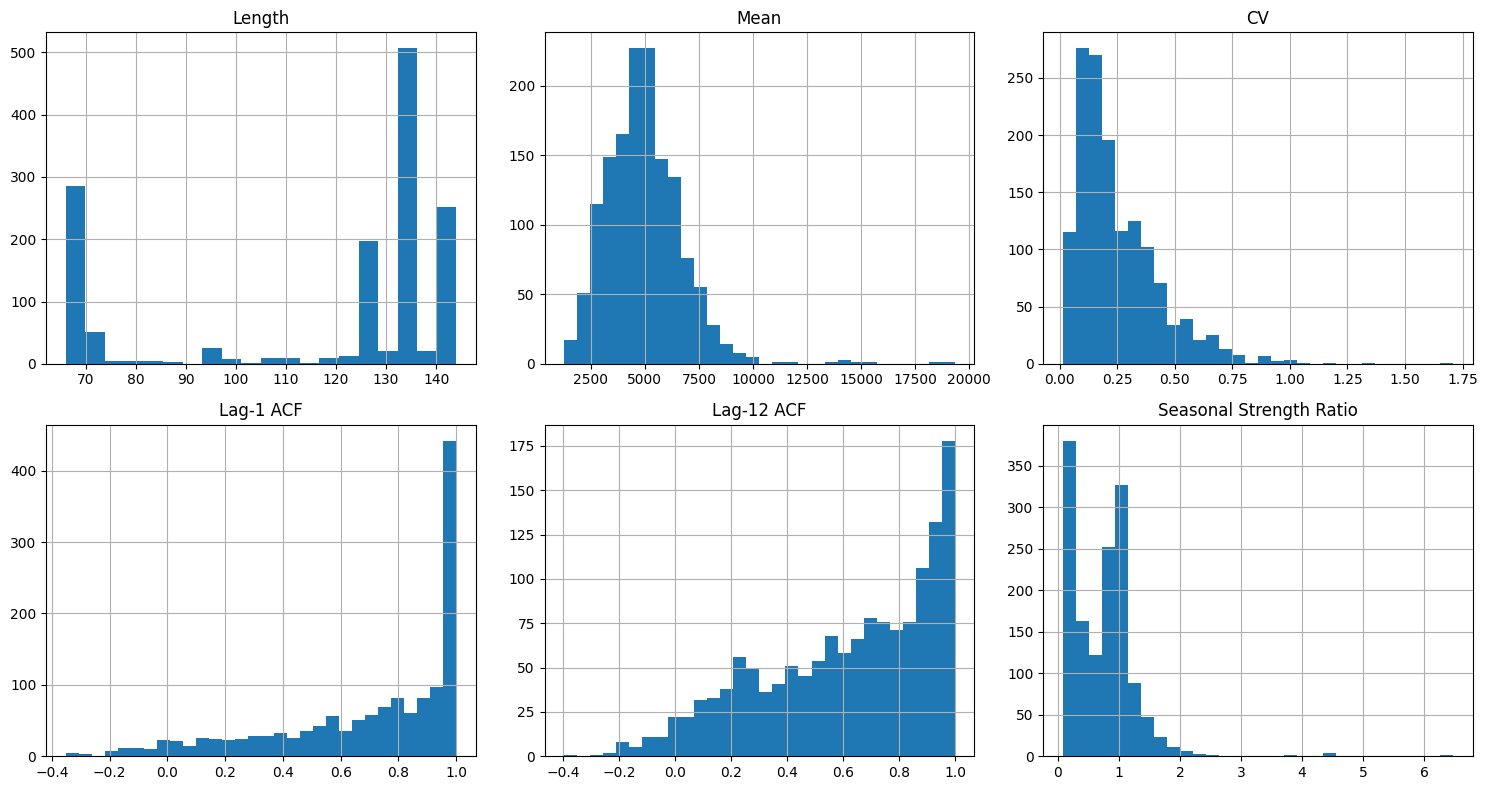

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

series_stats["length"].hist(ax=axes[0,0], bins=20)
axes[0,0].set_title("Length")

series_stats["mean"].hist(ax=axes[0,1], bins=30)
axes[0,1].set_title("Mean")

series_stats["cv"].hist(ax=axes[0,2], bins=30)
axes[0,2].set_title("CV")

series_stats["acf1"].hist(ax=axes[1,0], bins=30)
axes[1,0].set_title("Lag-1 ACF")

series_stats["acf12"].hist(ax=axes[1,1], bins=30)
axes[1,1].set_title("Lag-12 ACF")

series_stats["seasonal_ratio"].hist(ax=axes[1,2], bins=30)
axes[1,2].set_title("Seasonal Strength Ratio")


plt.tight_layout()
plt.show()

- `Temporal span distribution (length)`\
    Bimodal length distribution. Peaks around ~66-70 (5-6 years) and ~132-144 (11-12 years)
    18-months hold out is safe. Almost nothing in between.

- `Mean and coefficient of variation`\
    Strong right-skewed distribution centered around 5k with heavy tail up to 20k.
    log-transform or per-series z-score standardization. Also I am planning to use GBMs so squared-errors learners are scale-dominated and normalization might help alot in here.

    `Coefficient of variation` tells lower values indicate less dispersion. CV 0.0 - 0.25 relative variation is low but still this is conditioned on mean. This plot tells relative stability and hence one useful series level feature for splits. Many series are stable relative to their scale though some series are highly volatile since we can see long tail up to 1.75

- `Lag 1 ACF (Short-term persistance)`\
    Very strong auto-correlation compared lag 1 -> strong short term persistance.\
    We can assume <mark>Naive</mark> is strong. Lag1 feature is strong. And differencing would destroy this signal.

- `Lag 12 ACF (Long-term persistance)`\
    Wide distribution. Many series have strong yearly correlation. Still many series have weak, noisy seasonality. <mark>Seasonal Naive</mark> will be strong for many series and weak for many others.\
    `ETS` or `Theta` might fit good in here. For trees lag12 feature.

- `Seasonal Strength Ratio`\
    ratio = naive_error / seasonal_naive_error\
    ratio > 1 (seasonal naive better)\
    ratio ~ 1 (weak seasonality)\
    ratio < 1 (seasonal naive worse)\

    Right skewed with long tail up to 4.5 meaning some small amout of series have very strong seasonality.\
    Half of the series are better fit for <mark>Naive</mark>.\
    Another half of the series are better fit for <mark>Seasonal Naive</mark>.\
    Heterogeneous series

###Summary of data characteristics
- Strong persistance (lag1)
- Mixed seasonality (lag12 + seasonal ratio)
- Two dominant series length
- Heterogeneous scale and Volatility across series


###Model Assumptions
- Seasonal Naive
- Naive
- AutoETS and AutoTheta
- Global ML must
    - scale per series (z-score)
    - series-level metadata features
    - avoid heavy differencing
    - small lags

## Train / Test Split

18 observations

In [19]:
HORIZON = 18

# last dates per series
last_dates = df.groupby('unique_id')['ds'].max().reset_index()
last_dates.columns = ['unique_id', 'last_date']
df = df.merge(last_dates, on='unique_id')

# count months from most recent date till first date for each series
df['months_from_end'] = df.groupby('unique_id').cumcount(ascending=False)
df

,unique_id,ds,y,last_date,months_from_end
0,N1402,1990-01-01,2640.0,1995-08-01,67
1,N1402,1990-02-01,2640.0,1995-08-01,66
2,N1402,1990-03-01,2160.0,1995-08-01,65
3,N1402,1990-04-01,4200.0,1995-08-01,64
4,N1402,1990-05-01,3360.0,1995-08-01,63
...,...,...,...,...,...
167557,N2829,2006-07-01,1282.5,2006-11-01,4
167558,N2829,2006-08-01,1261.3,2006-11-01,3
167559,N2829,2006-09-01,1263.4,2006-11-01,2
167560,N2829,2006-10-01,1257.1,2006-11-01,1


In [20]:
train = df[df['months_from_end'] >= HORIZON].copy()
test = df[df['months_from_end'] < HORIZON].copy()

train = train[['unique_id', 'ds', 'y']]
test = test[['unique_id', 'ds', 'y']]

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train series: {train['unique_id'].nunique()}")
print(f"Test series: {test['unique_id'].nunique()}")


Train shape: (141858, 3)
Test shape: (25704, 3)
Train series: 1428
Test series: 1428


## Baselines
As findings from EDA, Naive and SeasonalNaive will explains best for these multiple series as a baseline

In [21]:
baseline_models = [
    SeasonalNaive(season_length=12),
    Naive()
]

sf_baselines = StatsForecast(
    models=baseline_models,
    freq='MS',
    n_jobs=-1
)

# fitted per-series
# scaling doesn't matter now in here yet
sf_baselines.fit(train)

StatsForecast(models=[SeasonalNaive,Naive])

In [22]:
forecasts_baselines = sf_baselines.predict(h=HORIZON)

In [23]:
eval_baseline_df = forecasts_baselines.merge(
    test,
    on=['unique_id', 'ds'],
    how='left'
)

In [24]:
scores_baseline = evaluate(
    eval_baseline_df,
    metrics=[smape],   # sMAPE ∈ [0, 2] where closer to 0 is better
    models=['SeasonalNaive', 'Naive']
)

In [25]:
stat_models = [
    AutoARIMA(season_length=12),
    AutoETS(season_length=12),
    AutoTheta(season_length=12)
]

sf_stats = StatsForecast(
    models=stat_models,
    freq='MS',
    n_jobs=-1
)

sf_stats.fit(train)

/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/statsforecast/arima.py:1519: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(
/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/statsforecast/arima.py:1519: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(
/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/statsforecast/arima.py:1519: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(


StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta])

In [26]:
forecasts_stats = sf_stats.predict(h=HORIZON)

In [27]:
eval_stats_df = forecasts_stats.merge(
    test,
    on=['unique_id', 'ds'],
    how='left'
)

In [28]:
scores_stats = evaluate(
    eval_stats_df,
    metrics=[smape],
    models=['AutoARIMA', 'AutoETS', 'AutoTheta']
)

In [29]:
scores_all = scores_baseline.merge(
    scores_stats,
    on='unique_id',
    how='inner'
)

scores_all

,unique_id,metric_x,SeasonalNaive,Naive,metric_y,AutoARIMA,AutoETS,AutoTheta
0,N1402,smape,0.351044,0.277484,smape,0.381421,0.381513,0.361210
1,N1403,smape,0.309464,0.316648,smape,0.193649,0.193398,0.150630
2,N1404,smape,0.178645,0.127946,smape,0.172343,0.153772,0.158427
3,N1405,smape,0.283145,0.229269,smape,0.144252,0.157244,0.149719
4,N1406,smape,0.173078,0.131440,smape,0.115301,0.154577,0.094124
...,...,...,...,...,...,...,...,...
1423,N2825,smape,0.008389,0.011122,smape,0.016284,0.012527,0.012910
1424,N2826,smape,0.108587,0.050102,smape,0.056777,0.053709,0.063289
1425,N2827,smape,0.081936,0.054994,smape,0.010030,0.011756,0.010205
1426,N2828,smape,0.014536,0.010701,smape,0.010701,0.010701,0.009978


#### Evaluation baselines + statistical models

In [30]:
models_all = [
    'Naive',
    'SeasonalNaive',
    'AutoARIMA',
    'AutoETS',
    'AutoTheta'
]

mean_smape = scores_all[models_all].mean().sort_values()
median_smape = scores_all[models_all].median().sort_values()

print("Mean sMAPE")
print(mean_smape)

print("\nMedian sMAPE")
print(median_smape)

winners_all = scores_all[models_all].idxmin(axis=1)
win_counts_all = winners_all.value_counts().sort_values(ascending=False)

print("\nWin counts")
print(win_counts_all)

Mean sMAPE
AutoETS          0.070790
AutoTheta        0.074840
AutoARIMA        0.076132
SeasonalNaive    0.086169
Naive            0.090904
dtype: float64

Median sMAPE
AutoARIMA        0.044711
AutoETS          0.045820
AutoTheta        0.046400
Naive            0.055034
SeasonalNaive    0.059803
dtype: float64

Win counts
AutoARIMA        387
AutoTheta        335
AutoETS          332
Naive            200
SeasonalNaive    174
Name: count, dtype: int64


## Machine Learning
